# Extract

In [1]:
import gzip             #importo la librería para leer los archivos gzip, formato de compresion en el que vinieron los archivos
import pandas as pd     #importo librería pandas que vamos a usar para el data frame
import ast              #importo librería ast que me ayuda a leer la gramatica abstracta

### Steamgames

In [2]:
#si bien se podría descomprimir el archivo y directamente leerlo de pandas, dado que futuras actualziaciones pueden venir como gzip, es preferible trabajarlos desde ese formato
with gzip.open('Datos_sin_procesar/steam_games.json.gz', 'rb') as f:
    df_steamgames=pd.read_json(f, lines=True)

### User Items

In [3]:
#comienzo con una lista para poder insertar cada línea del archivo
data=[]
with gzip.open('Datos_sin_procesar/users_items.json.gz', 'rb') as f:
    for line in f:
        #cargar la información usando ast, porque si se usa json se dan errores por sintacis de gramatica en el uso de comillas
        data.append(ast.literal_eval(line.decode('utf-8')))

# Convierto la lista a DataFrame
df_users_items = pd.DataFrame(data)

### User Reviews

In [4]:
#comienzo con una lista para poder insertar cada línea del archivo
data=[]
with gzip.open('Datos_sin_procesar/user_reviews.json.gz', 'rb') as f:
    for line in f:
        #cargar la información usando ast, porque si se usa json se dan errores por sintacis de gramatica en el uso de comillas
        data.append(ast.literal_eval(line.decode('utf-8')))

# Convierto la lista a DataFrame
df_user_reviews = pd.DataFrame(data)

In [ ]:
df_user_reviews

# Transorm

### Steamgames

In [5]:
#elimino los valores con todos nulos
df_steamgames.dropna(inplace= True, how='all')

In [6]:
df_steamgames[df_steamgames['id'].isnull()]

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
88384,None,None,None,None,http://store.steampowered.com/,None,None,None,None,19.99,0.0,NaN,None
119271,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",None,"[Single-player, Steam Achievements, Steam Trad...",19.99,0.0,NaN,"Rocksteady Studios,Feral Interactive (Mac)"


In [7]:
#se verifica sin con la url podemos obetener el id del juego
df_steamgames[['url','id']]
#se concluye que sí, y se pasa a asignar ese valor a los faltantes

,url,id
88310,http://store.steampowered.com/app/761140/Lost_...,761140.0
88311,http://store.steampowered.com/app/643980/Ironb...,643980.0
88312,http://store.steampowered.com/app/670290/Real_...,670290.0
88313,http://store.steampowered.com/app/767400/2222/,767400.0
88314,http://store.steampowered.com/app/773570/Log_C...,773570.0
...,...,...
120440,http://store.steampowered.com/app/773640/Colon...,773640.0
120441,http://store.steampowered.com/app/733530/LOGis...,733530.0
120442,http://store.steampowered.com/app/610660/Russi...,610660.0
120443,http://store.steampowered.com/app/658870/EXIT_...,658870.0


In [8]:
#se importa la libreria re para poder trabajar sobre la extracción del ID de la url, y se genera una función para este propósito
import re

def extraer_numero_url(url):
    if url is None:
        return None
    else:
        match = re.search(r'(\d+)', url)
        if match:
            return match.group(1)
        else:
            return None

#aplicamos la funcion a una columna auxiliar
df_steamgames['id_aux']=df_steamgames['url'].apply(extraer_numero_url)
#aplicamos la columna auxiliar a los valores nulos
df_steamgames['id'][df_steamgames['id'].isnull()]=df_steamgames['id_aux']
#eliminamos los id nulos
df_steamgames.dropna(subset=['id'], inplace=True)
#eliminamos la columna auxiliar
df_steamgames.drop(columns=['id_aux'], inplace=True)


C:\Users\feder\AppData\Local\Temp\ipykernel_11364\4277996820.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_steamgames['id'][df_steamgames['id'].isnull()]=df_steamgames['id_aux']
C:\Users\feder\AppData\Local\Temp\ipykernel_11364\4277996820.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[None '200260']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_steamgames['id'][df_steamgames['id'].isnull()]=df_steamgames['id_aux']


La columna genres tiene listas con los generos a los que puede pertenecer el juego. Para un mejor procesamiento a posteriori de los datos, se transforma esa columna en varias columnas dummies con cada uno de esos valores.
También se tiene la columna tags, pero que tiene muchos más valores. Algunos de ellos son las categorías, y también otros tipos de etiquetas. Se arma un dataframe para rellenar los valores faltantes de etiquetas.

In [9]:
#primero llenamos los nulos con valor [], para su posterior procesamiento

# Define una función para reemplazar los valores nulos con una lista vacía
def reemplazonulo(lst):
    return lst if isinstance(lst, list) else []

# Aplica la función a la columna con listas
df_steamgames['genres'] = df_steamgames['genres'].apply(reemplazonulo)
df_steamgames['tags'] = df_steamgames['tags'].apply(reemplazonulo)

In [10]:
df_steamgames['genres'].describe()

count     32134
unique      884
top          []
freq       3282
Name: genres, dtype: object

In [11]:
#Separo la columna de generos
df_genres = df_steamgames['genres'].apply(lambda x: pd.Series({val: 1 for val in x}))
#lleno los nulos con 0
df_genres.fillna(0, inplace=True)
#Se renombran columnas que tienen mal los nombres
df_genres.rename(columns={'Design &amp; Illustration':'Design & Illustration','Animation &amp; Modeling':'Animation & Modeling'}, inplace= True)
#armo una lista con los generos
list_Genres=df_genres.columns.to_list()


In [12]:
list_Genres

['Action',
 'Casual',
 'Indie',
 'Simulation',
 'Strategy',
 'Free to Play',
 'RPG',
 'Sports',
 'Adventure',
 'Racing',
 'Early Access',
 'Massively Multiplayer',
 'Animation & Modeling',
 'Video Production',
 'Utilities',
 'Web Publishing',
 'Education',
 'Software Training',
 'Design & Illustration',
 'Audio Production',
 'Photo Editing',
 'Accounting']

In [13]:
#Se genera el dataframe de de tags
df_tags = df_steamgames['tags'].apply(lambda x: pd.Series({val: 1 for val in x}))
df_tags.fillna(0, inplace=True)
#idem caso anterior con nombres mal importados
df_tags.rename(columns={'Design &amp; Illustration':'Design & Illustration','Animation &amp; Modeling':'Animation & Modeling'}, inplace= True)

In [14]:
#verificamos que todos los géneros están en la lista
tags=df_tags.columns.tolist()
genres=df_genres.columns.tolist()
for i in genres:
    if i in tags: print(i+' está')
    else:
        print(i+'no está')

Action está
Casual está
Indie está
Simulation está
Strategy está
Free to Play está
RPG está
Sports está
Adventure está
Racing está
Early Access está
Massively Multiplayer está
Animation & Modeling está
Video Production está
Utilities está
Web Publishing está
Education está
Software Training está
Design & Illustration está
Audio Production está
Photo Editing está
Accountingno está


In [15]:
#sacamos la columna accounting que no se encuentra en ningún tag
genres.remove('Accounting')

#completamos las categorías que son nulas en la columna de categoria pero si fueron etiquetadas usando los tags
for i in genres:
    for index, row in df_genres.iterrows():
        if row[i] == 0:
            df_genres.at[index, i] = df_tags.at[index, i]
df_steamgames=pd.concat([df_steamgames,df_genres], axis=1)

#eliminamos la columna genres, que tiene las listas de géneros
df_steamgames.drop('genres', axis=1,inplace= True)

#eliminamos los dataframes que ya no usamos
del df_genres
del df_tags

#volvemos a agregar el genero Accounting
genres.append('Accounting')

In [16]:
df_steamgames.columns

Index(['publisher', 'app_name', 'title', 'url', 'release_date', 'tags',
       'reviews_url', 'specs', 'price', 'early_access', 'id', 'developer',
       'Action', 'Casual', 'Indie', 'Simulation', 'Strategy', 'Free to Play',
       'RPG', 'Sports', 'Adventure', 'Racing', 'Early Access',
       'Massively Multiplayer', 'Animation & Modeling', 'Video Production',
       'Utilities', 'Web Publishing', 'Education', 'Software Training',
       'Design & Illustration', 'Audio Production', 'Photo Editing',
       'Accounting'],
      dtype='object')

In [17]:
#llenamos los nombres de app cuando faltan, con el título
df_steamgames['app_name'].fillna(df_steamgames['title'], inplace=True)

In [18]:
df_steamgames.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32134 entries, 88310 to 120444
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   publisher              24083 non-null  object 
 1   app_name               32133 non-null  object 
 2   title                  30085 non-null  object 
 3   url                    32134 non-null  object 
 4   release_date           30068 non-null  object 
 5   tags                   32134 non-null  object 
 6   reviews_url            32133 non-null  object 
 7   specs                  31465 non-null  object 
 8   price                  30757 non-null  object 
 9   early_access           32134 non-null  float64
 10  id                     32134 non-null  object 
 11  developer              28836 non-null  object 
 12  Action                 32134 non-null  float64
 13  Casual                 32134 non-null  float64
 14  Indie                  32134 non-null  float64
 15  Si

In [19]:
df_steamgames['release_date'] = pd.to_datetime(df_steamgames['release_date'], errors='coerce')
df_steamgames.loc[~df_steamgames['release_date'].notnull(), 'release_date'] = None
df_steamgames['release_year'] = df_steamgames['release_date'].dt.year

In [20]:
df_steamgames['release_year'] = df_steamgames['release_year'].fillna(0)
df_steamgames['release_year'] = df_steamgames['release_year'].astype(int)
for i in genres:
    df_steamgames[i] = df_steamgames[i].fillna(0)
    df_steamgames[i] = df_steamgames[i].astype(int)
df_steamgames['Accounting'] = df_steamgames['Accounting'].astype(int)

In [21]:
df_steamgames['id']=df_steamgames['id'].astype(int)

In [22]:
df_steamgames.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32134 entries, 88310 to 120444
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   publisher              24083 non-null  object        
 1   app_name               32133 non-null  object        
 2   title                  30085 non-null  object        
 3   url                    32134 non-null  object        
 4   release_date           29783 non-null  datetime64[ns]
 5   tags                   32134 non-null  object        
 6   reviews_url            32133 non-null  object        
 7   specs                  31465 non-null  object        
 8   price                  30757 non-null  object        
 9   early_access           32134 non-null  float64       
 10  id                     32134 non-null  int32         
 11  developer              28836 non-null  object        
 12  Action                 32134 non-null  int32         
 13  C

In [23]:
df_steamgames.columns.to_list()

['publisher',
 'app_name',
 'title',
 'url',
 'release_date',
 'tags',
 'reviews_url',
 'specs',
 'price',
 'early_access',
 'id',
 'developer',
 'Action',
 'Casual',
 'Indie',
 'Simulation',
 'Strategy',
 'Free to Play',
 'RPG',
 'Sports',
 'Adventure',
 'Racing',
 'Early Access',
 'Massively Multiplayer',
 'Animation & Modeling',
 'Video Production',
 'Utilities',
 'Web Publishing',
 'Education',
 'Software Training',
 'Design & Illustration',
 'Audio Production',
 'Photo Editing',
 'Accounting',
 'release_year']

In [24]:
df_steamgames.drop(['publisher','app_name','title','url','release_date','tags','reviews_url','specs','price','early_access',
                                 'developer'],axis=1,inplace=True)

In [25]:
'''
#Se genera un diccionario con una lista de los Id de cada Juego por categoría, para su posterior uso
Dict_GamesCat={}
for genre in genres:
    # Selecciona las filas donde el género es igual a 1
    juegos = df_steamgames[df_steamgames[genre] == 1]['id'].tolist()
    # Agrega la lista de juegos al diccionario
    Dict_GamesCat[genre] = juegos

GamesId=df_steamgames['id'].unique()
#Se genera un diccionario con el año de lanzamiento de cada Juego, para su posterior uso
# Armo el diccionario
GameRY = {}
for game in GamesId:
    release_year_series = df_steamgames['release_year'][df_steamgames['id'] == game]
    if release_year_series.empty:
        GameRY[game] = ''
    else:
        aux = release_year_series.tolist()
        if aux:
            GameRY[game] = aux[0]
        else:
            GameRY[game] = ''  # Cuando no se encuentra el año...    
'''

"\n#Se genera un diccionario con una lista de los Id de cada Juego por categoría, para su posterior uso\nDict_GamesCat={}\nfor genre in genres:\n    # Selecciona las filas donde el género es igual a 1\n    juegos = df_steamgames[df_steamgames[genre] == 1]['id'].tolist()\n    # Agrega la lista de juegos al diccionario\n    Dict_GamesCat[genre] = juegos\n\nGamesId=df_steamgames['id'].unique()\n#Se genera un diccionario con el año de lanzamiento de cada Juego, para su posterior uso\n# Armo el diccionario\nGameRY = {}\nfor game in GamesId:\n    release_year_series = df_steamgames['release_year'][df_steamgames['id'] == game]\n    if release_year_series.empty:\n        GameRY[game] = ''\n    else:\n        aux = release_year_series.tolist()\n        if aux:\n            GameRY[game] = aux[0]\n        else:\n            GameRY[game] = ''  # Cuando no se encuentra el año...    \n"

### User Items

In [26]:
len(df_users_items)

88310

In [27]:
df_users_items['items'][0]

[{'item_id': '10',
  'item_name': 'Counter-Strike',
  'playtime_forever': 6,
  'playtime_2weeks': 0},
 {'item_id': '20',
  'item_name': 'Team Fortress Classic',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '30',
  'item_name': 'Day of Defeat',
  'playtime_forever': 7,
  'playtime_2weeks': 0},
 {'item_id': '40',
  'item_name': 'Deathmatch Classic',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '50',
  'item_name': 'Half-Life: Opposing Force',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '60',
  'item_name': 'Ricochet',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '70',
  'item_name': 'Half-Life',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '130',
  'item_name': 'Half-Life: Blue Shift',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '300',
  'item_name': 'Day of Defeat: Source',
  'playtime_forever': 4733,
  'playtime_2weeks': 0},
 {'item_id': '240',
  'item_name': 'Counter-Strike: S

Se posee en la columna items listas con diccionarios. Cada diccionario tiene 4 atributos. Se genera una fila para cada diccionario, y 4 columnas posteriores a partir del diccionario

In [28]:
#primero se inserta una fila por cada diccionario de la columna item
df_users_items=df_users_items.explode('items')

In [29]:
df_users_items['items'][0]

0    {'item_id': '10', 'item_name': 'Counter-Strike...
0    {'item_id': '20', 'item_name': 'Team Fortress ...
0    {'item_id': '30', 'item_name': 'Day of Defeat'...
0    {'item_id': '40', 'item_name': 'Deathmatch Cla...
0    {'item_id': '50', 'item_name': 'Half-Life: Opp...
                           ...                        
0    {'item_id': '289130', 'item_name': 'Endless Le...
0    {'item_id': '268500', 'item_name': 'XCOM 2', '...
0    {'item_id': '461640', 'item_name': 'Sins Of Th...
0    {'item_id': '379720', 'item_name': 'DOOM', 'pl...
0    {'item_id': '273350', 'item_name': 'Evolve Sta...
Name: items, Length: 277, dtype: object

In [30]:
df_users_items

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '10', 'item_name': 'Counter-Strike..."
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '20', 'item_name': 'Team Fortress ..."
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '30', 'item_name': 'Day of Defeat'..."
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '40', 'item_name': 'Deathmatch Cla..."
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '50', 'item_name': 'Half-Life: Opp..."
...,...,...,...,...,...
88308,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...,"{'item_id': '373330', 'item_name': 'All Is Dus..."
88308,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...,"{'item_id': '388490', 'item_name': 'One Way To..."
88308,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...,"{'item_id': '521570', 'item_name': 'You Have 1..."
88308,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...,"{'item_id': '519140', 'item_name': 'Minds Eyes..."


In [31]:
df_users_items = df_users_items.reset_index(drop=True)

In [32]:
df_users_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5170015 entries, 0 to 5170014
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      object
 1   items_count  int64 
 2   steam_id     object
 3   user_url     object
 4   items        object
dtypes: int64(1), object(4)
memory usage: 197.2+ MB


In [33]:
#luego se arma un dataframe nuevo a partir de los diccionarios de item, con una columna por cada atributo
# el metodo normal sería este, pero tarda mucho, con lo cual buscamos extraer columna por columna df_users_items_items=df_users_items['items'].apply(pd.Series)

In [34]:
def obtener_elemento(diccionario, clave_busqueda):
    if isinstance(diccionario, dict):
        return diccionario.get(clave_busqueda)
    else:
        return diccionario

df_users_items['item_id'] = df_users_items['items'].apply(lambda x: obtener_elemento(x, 'item_id'))
df_users_items['item_name'] = df_users_items['items'].apply(lambda x: obtener_elemento(x, 'item_name'))
df_users_items['playtime_forever'] = df_users_items['items'].apply(lambda x: obtener_elemento(x, 'playtime_forever'))
df_users_items['playtime_2weeks'] = df_users_items['items'].apply(lambda x: obtener_elemento(x, 'playtime_2weeks'))

In [35]:
#Saco la columna items que ya no es util
df_users_items.drop('items', axis=1,inplace= True)

In [36]:
df_users_items.columns

Index(['user_id', 'items_count', 'steam_id', 'user_url', 'item_id',
       'item_name', 'playtime_forever', 'playtime_2weeks'],
      dtype='object')

In [37]:
len(df_users_items['item_id'].unique())

10979

In [38]:
len(df_users_items['item_name'].unique())

10948

In [39]:
df_users_items = df_users_items.dropna(subset=['item_id', 'item_name'], how='all')

In [40]:
df_users_items

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,10,Counter-Strike,6.0,0.0
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,20,Team Fortress Classic,0.0,0.0
2,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,30,Day of Defeat,7.0,0.0
3,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,40,Deathmatch Classic,0.0,0.0
4,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,50,Half-Life: Opposing Force,0.0,0.0
...,...,...,...,...,...,...,...,...
5170009,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...,346330,BrainBread 2,0.0,0.0
5170010,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...,373330,All Is Dust,0.0,0.0
5170011,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...,388490,One Way To Die: Steam Edition,3.0,3.0
5170012,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...,521570,You Have 10 Seconds 2,4.0,4.0


### User Reviews

In [41]:
df_user_reviews['reviews'][0]

[{'funny': '',
  'posted': 'Posted November 5, 2011.',
  'last_edited': '',
  'item_id': '1250',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.'},
 {'funny': '',
  'posted': 'Posted July 15, 2011.',
  'last_edited': '',
  'item_id': '22200',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': "It's unique and worth a playthrough."},
 {'funny': '',
  'posted': 'Posted April 21, 2011.',
  'last_edited': '',
  'item_id': '43110',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': 'Great atmosphere. The gunplay can be a bit chunky at times but at the end of the day this game is definitely worth it and I hope they do a sequel...so buy the game so I get a sequel!'}]

Cada objeto de la columna review es una lista que tiene varios valores de diccionario, de 7 atributos 'funny', 'posted',   'last_edited', 'item_id', 'helpful', 'recommend', 'review'. Se debe transformar cada diccionario en una fila, y cada uno de estos 7 atriburos en una columna, de manera tal que el dataframe refleje la realidad de datos que tenemos

In [42]:
#paso cada lista a una fila, aplicando metodo explode
df_user_reviews=df_user_reviews.explode('reviews')

In [43]:
#paso cada atributo del diccionario a una columna nueva, aplicando metodo apply
df_user_reviews_exp=df_user_reviews['reviews'].apply(pd.Series)

In [44]:
#junto el dataframe original y las nuevas columnas
df_user_reviews=pd.concat([df_user_reviews, df_user_reviews_exp], axis=1)
#elimino la columna original
df_user_reviews.drop(['reviews','user_url', 'funny', 'last_edited', 
                      'helpful', 0], axis=1, inplace=True)

In [45]:
df_user_reviews

,user_id,posted,item_id,recommend,review
0,76561197970982479,"Posted November 5, 2011.",1250,True,Simple yet with great replayability. In my opi...
0,76561197970982479,"Posted July 15, 2011.",22200,True,It's unique and worth a playthrough.
0,76561197970982479,"Posted April 21, 2011.",43110,True,Great atmosphere. The gunplay can be a bit chu...
1,js41637,"Posted June 24, 2014.",251610,True,I know what you think when you see this title ...
1,js41637,"Posted September 8, 2013.",227300,True,For a simple (it's actually not all that simpl...
...,...,...,...,...,...
25797,76561198312638244,Posted July 10.,70,True,a must have classic from steam definitely wort...
25797,76561198312638244,Posted July 8.,362890,True,this game is a perfect remake of the original ...
25798,LydiaMorley,Posted July 3.,273110,True,had so much fun plaing this and collecting res...
25798,LydiaMorley,Posted July 20.,730,True,:D


In [46]:
from textblob import TextBlob
df_user_reviews['review'] = df_user_reviews['review'].astype(str)


In [47]:

df_user_reviews['polarity'] = df_user_reviews['review'].apply(lambda text: TextBlob(text).sentiment.polarity)

In [48]:
import matplotlib.pyplot as plt

(array([1.9600e+02, 1.3000e+01, 0.0000e+00, 0.0000e+00, 5.0000e+00,
        9.0000e+00, 9.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00,
        9.4000e+01, 4.0000e+00, 7.0000e+01, 4.0000e+00, 2.6000e+01,
        1.6700e+02, 1.3000e+01, 2.0000e+01, 5.1000e+01, 4.7000e+01,
        8.3000e+01, 2.4000e+01, 7.8000e+01, 2.6000e+01, 3.7000e+01,
        3.4000e+02, 3.0000e+01, 9.2000e+01, 6.4000e+01, 6.5000e+01,
        1.7440e+03, 1.1900e+02, 1.7200e+02, 1.4100e+02, 2.9300e+02,
        1.4900e+02, 1.9900e+02, 3.0900e+02, 2.4000e+02, 8.0400e+02,
        2.5500e+02, 3.8300e+02, 5.5200e+02, 6.2700e+02, 8.5200e+02,
        5.6100e+02, 8.2200e+02, 1.0020e+03, 1.0370e+03, 9.1300e+02,
        1.4095e+04, 1.2080e+03, 1.7440e+03, 1.4290e+03, 2.0370e+03,
        1.2460e+03, 1.4540e+03, 1.9410e+03, 1.4050e+03, 9.8100e+02,
        2.2860e+03, 1.0500e+03, 1.3440e+03, 9.2800e+02, 2.4650e+03,
        5.7000e+02, 6.7200e+02, 7.0000e+02, 6.3500e+02, 8.4000e+02,
        2.6600e+02, 3.6100e+02, 2.6700e+02, 3.61

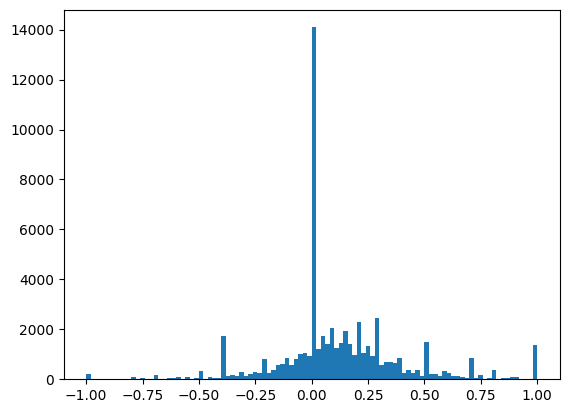

In [49]:
plt.hist(df_user_reviews['polarity'], bins=100)

In [50]:
df_user_reviews['sentiment_analysis'] = df_user_reviews['polarity'].apply(lambda x: 0 if x < 0 else (1 if x == 0 else 2))

In [51]:
df_user_reviews.columns

Index(['user_id', 'posted', 'item_id', 'recommend', 'review', 'polarity',
       'sentiment_analysis'],
      dtype='object')

In [52]:
df_user_reviews.drop(['review','polarity'], axis=1, inplace=True)

In [53]:
#no es necesario, es para poner la fecha pero no se usa
df_user_reviews['date'] = df_user_reviews['posted'].str.extract(r'(\w+\s\d+(?:,\s\d{4})?)')
df_user_reviews['date'] = pd.to_datetime(df_user_reviews['date'], format='%B %d, %Y', errors='coerce')

In [54]:
df_user_reviews['year'] = df_user_reviews['date'].dt.year

In [55]:
# Convertir los NaN a 0 en la columna 'year'
df_user_reviews['year'] = df_user_reviews['year'].fillna(0)

# Convertir la columna 'year' a tipo entero
df_user_reviews['year'] = df_user_reviews['year'].astype(int)

**tengo que ver que hago con los que no tienen año**

In [56]:
df_user_reviews.reset_index()

,index,user_id,posted,item_id,recommend,sentiment_analysis,date,year
0,0,76561197970982479,"Posted November 5, 2011.",1250,True,2,2011-11-05,2011
1,0,76561197970982479,"Posted July 15, 2011.",22200,True,2,2011-07-15,2011
2,0,76561197970982479,"Posted April 21, 2011.",43110,True,2,2011-04-21,2011
3,1,js41637,"Posted June 24, 2014.",251610,True,2,2014-06-24,2014
4,1,js41637,"Posted September 8, 2013.",227300,True,0,2013-09-08,2013
...,...,...,...,...,...,...,...,...
59328,25797,76561198312638244,Posted July 10.,70,True,2,NaT,0
59329,25797,76561198312638244,Posted July 8.,362890,True,2,NaT,0
59330,25798,LydiaMorley,Posted July 3.,273110,True,2,NaT,0
59331,25798,LydiaMorley,Posted July 20.,730,True,2,NaT,0


In [57]:
#lleno los años faltantes con el año de lanzamiento del juego o con el año 2016
df_steamgames.reset_index()

# Definir una función personalizada para aplicar la lógica deseada
def fill_year(row):
    if row['year'] == 0:
        # Obtener las filas de df_steamgames que cumplen con la condición
        steamgame_rows = df_steamgames[df_steamgames['id'] == row['item_id']]
        
        if not steamgame_rows.empty:
            # Si se encontraron filas, obtener el año de la primera fila y verificar si es mayor a 2016
            release_year = steamgame_rows['release_year'].iloc[0]
            return max(release_year, 2016)
        else:
            # Si no se encontraron filas, retornar 2016
            return 2016
    else:
        return row['year']

# Aplicar la función personalizada a la columna 'year' utilizando apply
df_user_reviews['year'] = df_user_reviews.apply(fill_year, axis=1)

# Convertir la columna 'year' a tipo entero
df_user_reviews['year'] = df_user_reviews['year'].astype(int)

In [58]:
#Agrupo lo que me sirve
df_user_item_played_year = df_user_reviews.groupby(['item_id', 'user_id', 'year']).size().reset_index(name='count')
df_user_item_played_year.drop('count', axis=1, inplace=True)
df_user_item_played_year['item_id']=df_user_item_played_year['item_id'].astype(int)

### Combinaciones

#### df_genres_detail

In [59]:
#Agrego las horas totales de cada juego
#primero armo un dataframe que es la suma total de horas jugadas de cada juego
df_hoursxgame = df_users_items.groupby(by=['item_id', 'item_name'])['playtime_forever'].sum().reset_index()
#cambio el tipo de item_id a integer
df_hoursxgame['item_id']=df_hoursxgame['item_id'].astype(int)
#agrego las horas al dataframe de steamgames
df_steamgames = df_steamgames.merge(df_hoursxgame[['item_id', 'playtime_forever']], left_on='id', right_on='item_id', how='left')
#elimino la columna de más
df_steamgames.drop(['item_id'],axis=1, inplace= True)

In [60]:
#genero una lista, que luego paso a dataframe, en la que busco el año con el maximo de horas jugadas
genres_RY_list=[]
#voy iterando por cada género
for i in genres:
    # genero un dataframe con cada año de lanzamiento y las horas jugadas, un agrupado del dataframe steamgames
    df_append = df_steamgames[df_steamgames[i] == 1].groupby(by=['release_year'])['playtime_forever'].sum().reset_index()
    # Encuentro el año con la máxima cantidad de horas jugadas
    max_hours_year = df_append.loc[df_append['playtime_forever'].idxmax(), 'release_year']
    # Agrego los datos a la lista de géneros y años de máximas horas jugadas
    genres_RY_list.append({'Genre': i, 'RYMaxHours': max_hours_year})
df_genres=pd.DataFrame(genres_RY_list)
df_genres['Genre']=df_genres['Genre'].astype(str)

In [61]:
#cambio el tipo de valor de item id
df_users_items['item_id']=df_users_items['item_id'].astype(int)
#Incluyo los generos en el dataframe de los usuarios
df_users_items = df_users_items.merge(df_steamgames, left_on='item_id', right_on='id', how='left')
#cambio nomnbre y elimino columnas duplicadas
df_users_items.rename(columns={'playtime_forever_x':'playtime_forever'}, inplace=True)
df_users_items.drop('playtime_forever_y', axis=1, inplace=True)
#convvierto a enteros las columnas de generos para que ocupe menos memoria
for i in genres:
    df_users_items[i] = df_users_items[i].fillna(0).astype(int)

In [62]:
## JUGADOR QUE MAS HORAS JUGO

#genero una lista, que luego paso a dataframe, en la que busco el jugador con el maximo de horas jugadas
genres_MaxPlayer_list=[]
#voy iterando por cada género
for index, row in df_genres.iterrows():
    genero = row['Genre']
    # genero un dataframe con cada jugador y las horas jugadas de ese genero, un agrupado del dataframe df_users_items
    df_append = df_users_items[df_users_items[genero] == 1].groupby(by=['user_id'])['playtime_forever'].sum().reset_index()
    if not df_append.empty:
        # Encontrar el jugador con la máxima cantidad de horas jugadas
        max_hours_player = df_append.loc[df_append['playtime_forever'].idxmax(), 'user_id']
    else:
    # Manejar el caso en que la Serie esté vacía
        max_hours_player= 'Player Not Found'
    df_genres.at[index, 'PlayerMH'] = max_hours_player


C:\Users\feder\AppData\Local\Temp\ipykernel_11364\3941897929.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Sp3ctre' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_genres.at[index, 'PlayerMH'] = max_hours_player


In [63]:
## AÑO JUGADOR POR CADA JUGADOR

#primero debemos incluir el año en que jugó en una columna de users_items
df_users_items=df_users_items.merge(df_user_item_played_year, on=['item_id','user_id'],how='left')

# Itero sobre las filas de df_genresplayer
for index, row in df_genres.iterrows():
    genero = row['Genre']
    jugador = row['PlayerMH']
    
    # Filtro df_users_items para obtener las horas jugadas del jugador por género y año
    df_append_player = df_users_items[(df_users_items[genero] == 1) & (df_users_items['user_id'] == jugador)].groupby(by=['year'])['playtime_forever'].sum().reset_index()
    df_append_player = df_append_player.sort_values(by='playtime_forever', ascending=False)
    
    # Obtengo los años jugados y horas jugadas
    years_by_player = []
    for j in range(min(3, len(df_append_player))):
        this_year = '{Año: ' + str(int(df_append_player['year'].iloc[j])) + ', Horas: ' + str(int(df_append_player['playtime_forever'].iloc[j])) + '}'
        years_by_player.append(this_year)
    years_by_player=str(years_by_player)

    # Asigno la lista de años jugados y horas jugadas a la columna 'Years Played' en la fila actual
    df_genres.at[index, 'Years Played by player'] = years_by_player
    

C:\Users\feder\AppData\Local\Temp\ipykernel_11364\1878558227.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['{Año: 2015, Horas: 318642}', '{Año: 2016, Horas: 197937}']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_genres.at[index, 'Years Played by player'] = years_by_player


In [67]:
df_genres.to_csv('Datos_procesados/genres_analysis.csv')

#### df_year_detail

# Load

### PlayTimeGenre

In [73]:
df_genres

,Genre,RYMaxHours,PlayerMH,Years Played by player
0,Action,2012,Sp3ctre,"['{Año: 2015, Horas: 318642}', '{Año: 2016, Ho..."
1,Casual,2015,REBAS_AS_F-T,"['{Año: 2012, Horas: 9268}']"
2,Indie,2006,REBAS_AS_F-T,[]
3,Simulation,2006,shinomegami,"['{Año: 2015, Horas: 674623}']"
4,Strategy,2012,shinomegami,"['{Año: 2015, Horas: 594498}']"
5,Free to Play,2013,shinomegami,"['{Año: 2015, Horas: 611007}']"
6,RPG,2013,shinomegami,"['{Año: 2015, Horas: 530882}', '{Año: 2014, Ho..."
7,Sports,2015,76561197995725436,[]
8,Adventure,2006,REBAS_AS_F-T,"['{Año: 2012, Horas: 9268}', '{Año: 2015, Hora..."
9,Racing,2015,DownSyndromeKid,[]


In [77]:
genero='Action'
df_genres[df_genres['Genre']==genero]['RYMaxHours'].item()

2012

In [86]:
'''Debe devolver año con mas horas jugadas para dicho género.
Ejemplo de retorno: '{"Año de lanzamiento con más horas jugadas para Género X" : '2013} '''

#tengo que leer primero el dataframe df_genres de un csv.
#genres=df_genres['Genre'].to_list()



def PlayTimeGenre( genero : str ):
    # mensaje si se ingresa un tipo incorrecto o bien no se escribe bien el género. Devuelve el listado de géneros.
    if (type(genero)!= str) or (genero not in genres): print("No se encuentra el género indicado. \nEste es un listado de los géneros con los que contamos: \n" + ', '.join(genres))
    else:
        Anio= df_genres[df_genres['Genre']==genero]['RYMaxHours'].item()
        print('{"Año de lanzamiento con más horas jugadas para Género X" : '+str(Anio)+'}')
        

In [89]:
PlayTimeGenre('jdkas')

No se encuentra el género indicado. 
Este es un listado de los géneros con los que contamos: 
Action, Casual, Indie, Simulation, Strategy, Free to Play, RPG, Sports, Adventure, Racing, Early Access, Massively Multiplayer, Animation & Modeling, Video Production, Utilities, Web Publishing, Education, Software Training, Design & Illustration, Audio Production, Photo Editing, Accounting


In [84]:
PlayTimeGenre('Action')

{"Año de lanzamiento con más horas jugadas para Género X" : 2012}


### UserForGenre

In [94]:
'''Debe devolver el usuario que acumula más horas jugadas para el género dado y una lista de la acumulación de horas 
jugadas por año.
Ejemplo de retorno: {"Usuario con más horas jugadas para Género X" : us213ndjss09sdf, 
"Horas jugadas":[{Año: 2013, Horas: 203}, {Año: 2012, Horas: 100}, {Año: 2011, Horas: 23}]} '''

def UserForGenre( genero : str ):
    # mensaje si se ingresa un tipo incorrecto o bien no se escribe bien el género. Devuelve el listado de géneros.
    if (type(genero)!= str) or (genero not in genres): print("No se encuentra el género indicado. \nEste es un listado de los géneros con los que contamos: \n" + ', '.join(genres))
    else:
        jugador= df_genres[df_genres['Genre']==genero]['PlayerMH'].item()
        detalleanio= df_genres[df_genres['Genre']==genero]['Years Played by player'].item()
        print('{"Usuario con más horas jugadas para Género X" : '+str(jugador)+', \n"Horas jugadas":'+str(detalleanio))

In [95]:
UserForGenre('Action')

{"Usuario con más horas jugadas para Género X" : Sp3ctre, 
"Horas jugadas":['{Año: 2015, Horas: 318642}', '{Año: 2016, Horas: 197937}']


### UsersRecommend

In [ ]:
'''Devuelve el top 3 de juegos MÁS recomendados por usuarios para el año dado. 
(reviews.recommend = True y comentarios positivos/neutrales)
Ejemplo de retorno: [{"Puesto 1" : X}, {"Puesto 2" : Y},{"Puesto 3" : Z}]'''

def UsersRecommend( año : int ):

### UsersNotRecommend

In [ ]:
''' Devuelve el top 3 de juegos MENOS recomendados por usuarios para el año dado. 
(reviews.recommend = False y comentarios negativos)
Ejemplo de retorno: [{"Puesto 1" : X}, {"Puesto 2" : Y},{"Puesto 3" : Z}]'''

def UsersNotRecommend( año : int ):

### sentiment_analysis

In [ ]:
''' Según el año de lanzamiento, se devuelve una lista con la cantidad de registros de reseñas de usuarios 
que se encuentren categorizados con un análisis de sentimiento.
# Ejemplo de retorno: {Negative = 182, Neutral = 120, Positive = 278} '''

def sentiment_analysis( año : int ):

# EDA

# ML

In [ ]:
'''Si es un sistema de recomendación item-item:
Ingresando el id de producto, deberíamos recibir una lista con 5 juegos recomendados similares al ingresado.'''

def recomendacion_juego( id de producto ):

In [ ]:
'''Si es un sistema de recomendación user-item:
 Ingresando el id de un usuario, deberíamos recibir una lista con 5 juegos recomendados para dicho usuario.
'''

def recomendacion_usuario( id de usuario ):